In [1]:
import pandas as pd

df_train = pd.read_csv('Dataset/conjunto_de_treinamento.csv')
df_train.shape

(4683, 21)

In [2]:
def DataProcessing1(df):
    df.drop(columns=['Id'], inplace=True)
    df.drop(columns=['diferenciais'], inplace=True)

    df['tipo'] = df['tipo'].map({'Apartamento': 1, 'Casa': 2})
    df.fillna(0.5, inplace=True)
    df['tipo_vendedor'] = df['tipo_vendedor'].map({'Imobiliaria': 0, 'Pessoa Fisica': 1})
    return df

In [3]:
def DataProcessing2(df):
    # Calcula a média dos valores dos imóveis por bairro
    mean_encoded = df.groupby('bairro')['preco'].mean()

    # Mapeia os valores médios dos imóveis por bairro para os respectivos bairros
    df['Bairro_Encoded'] = df['bairro'].map(mean_encoded)

    # Obtém a lista de todas as colunas no DataFrame
    colunas = df.columns.tolist()

    # Move a coluna 'Bairro_Encoded' para a posição desejada, logo após a coluna 'Bairro'
    colunas.insert(colunas.index('bairro') + 1, colunas.pop(colunas.index('Bairro_Encoded')))

    # Reindexa o DataFrame com as colunas na nova ordem
    df = df.reindex(columns=colunas)
    df.drop(columns=['bairro'], inplace=True)
    return df


In [4]:
# # Verifica se a coluna 'tipo' contém valores NaN
# df_train['tipo'].fillna(-1, inplace=True)
# tem_nan = df_train['tipo'].isna().any()
# print(df_train['tipo'].value_counts()
# )
# # Exibe o resultado
# tem_nan

In [5]:
df_test = pd.read_csv('Dataset/conjunto_de_teste.csv')

df_train = DataProcessing1(df_train)
df_test = DataProcessing1(df_test)
df_train = DataProcessing2(df_train)


df_train.shape

(4683, 19)

In [6]:

df_test['bairro'] = df_train['Bairro_Encoded']
df_test['bairro'].fillna(df_test['bairro'].mean(), inplace=True)
df_test.head()


,tipo,bairro,tipo_vendedor,quartos,suites,vagas,area_util,area_extra,churrasqueira,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,sauna,vista_mar
0,1.0,448228.333333,0,4,4,3,182,0,0,0,0,1,0,0,0,0,0,0
1,1.0,506917.862222,0,2,0,1,85,0,0,0,0,0,0,0,0,0,0,0
2,1.0,416455.325153,0,3,1,2,115,20,1,0,1,0,0,0,0,0,0,0
3,1.0,876340.604753,0,3,0,1,92,0,0,0,0,0,0,0,0,0,0,0
4,1.0,599055.747525,0,3,1,1,65,0,0,0,1,0,0,0,0,0,0,0


In [7]:
X_train = df_train.iloc[:, :-1].values
y_train = df_train.iloc[:, -1].values
X_test = df_test.iloc[:, :].values

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(df_train.iloc[:, :-1].values, df_train.iloc[:, -1].values, test_size=0.1, random_state=0)


X_train.shape, X_test.shape


((4683, 18), (2000, 18))

In [8]:
# Conta o número de valores NaN em cada coluna
contagem_nan = df_test.isnull().sum()

# Exibe a contagem de valores NaN
print(contagem_nan)


tipo              0
bairro            0
tipo_vendedor     0
quartos           0
suites            0
vagas             0
area_util         0
area_extra        0
churrasqueira     0
estacionamento    0
piscina           0
playground        0
quadra            0
s_festas          0
s_jogos           0
s_ginastica       0
sauna             0
vista_mar         0
dtype: int64


In [9]:
# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)

import numpy as np
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=1)  # Defina o número de vizinhos (k) desejado
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# mse = np.mean((y_pred - y_test) ** 2)
# print(mse)


In [10]:
# Criar DataFrame com a coluna 'Id' e 'preco' contendo os valores de y_pred
df_resultado = pd.DataFrame({'Id': range(len(y_pred)), 'preco': y_pred})

# Salvar o DataFrame em um arquivo CSV
df_resultado.to_csv('resultado.csv', index=False)
df_resultado.shape

(2000, 2)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_knn(X_train, y_train, k, col_index):
    # Ajusta o modelo KNN com o número de vizinhos (k) desejado
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)
    
    # Obtém as previsões do modelo
    y_pred = model.predict(X_train)
    
    colors = np.arange(len(y_train))

    # Cria um gráfico de dispersão das previsões versus os valores reais, com cores diferentes para cada variável
    plt.scatter(y_train, y_pred, c=colors, cmap='rainbow')  # cmap define a paleta de cores desejada
    plt.xlabel('Valor Real')
    plt.ylabel('Valor Previsto')
    plt.title(f'Gráfico de Dispersão KNN (k={k})')
    plt.colorbar(label='Amostras')
    plt.show()
    
    # Calcula a correlação entre a coluna selecionada e as outras colunas
    col_name = df_train.columns[col_index]
    df = pd.DataFrame(X_train, columns=df_train.columns[:-1])
    df['Valor Real'] = y_train
    correlation = df.corr()[col_name]
    
    # Plota um gráfico de barras da correlação
    plt.figure(figsize=(10, 6))
    sns.barplot(x=correlation.index, y=correlation.values)
    plt.xlabel('Colunas')
    plt.ylabel('Correlação')
    plt.title(f'Correlação da Coluna "{col_name}" com as Outras Colunas')
    plt.xticks(rotation=90)
    plt.show()


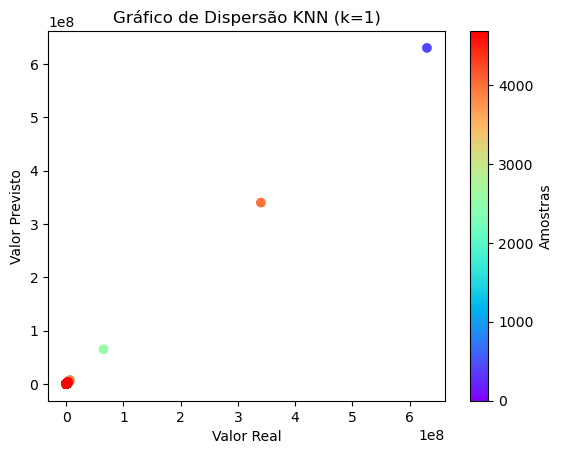

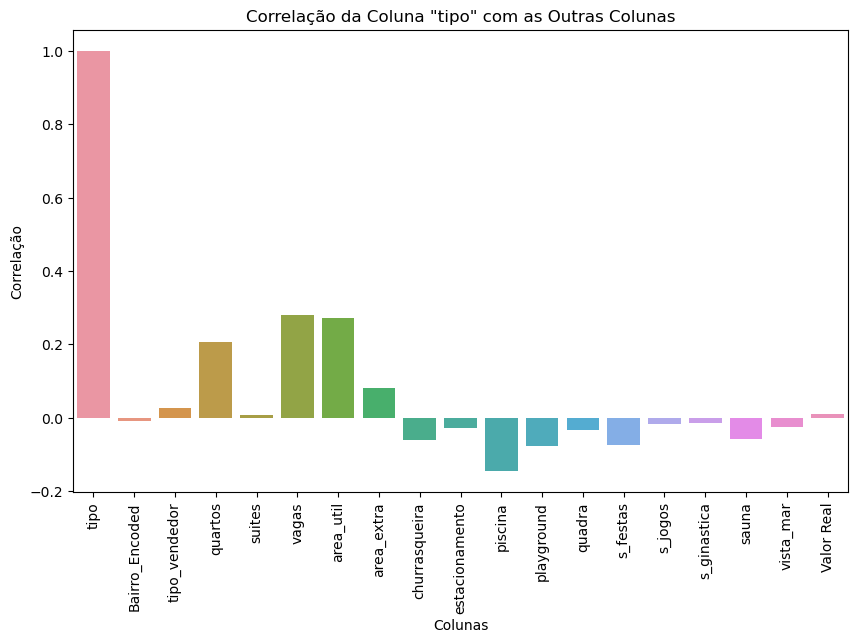

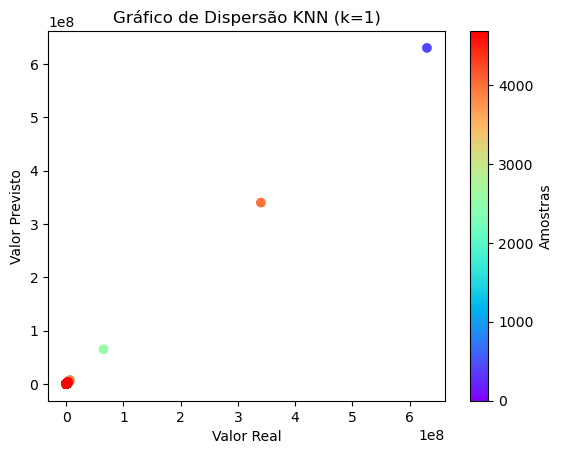

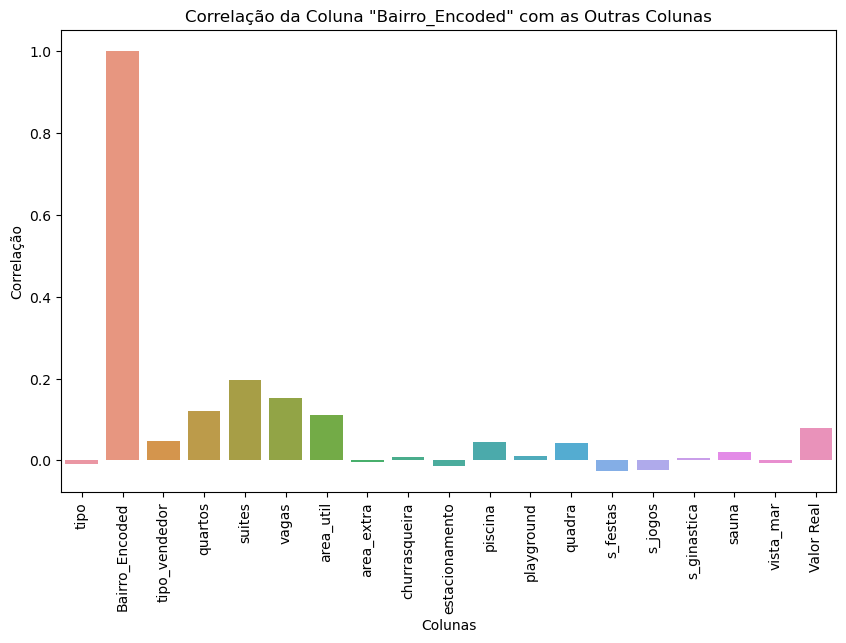

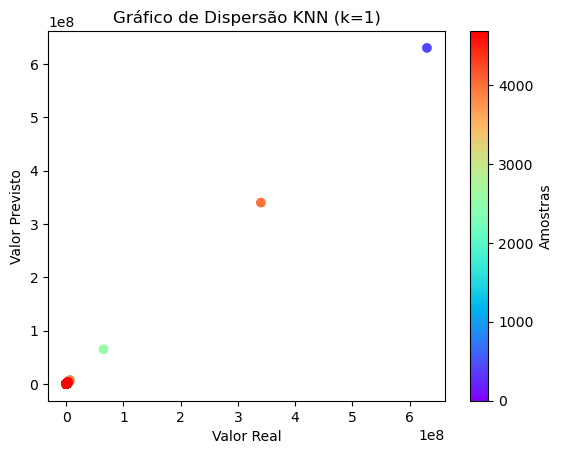

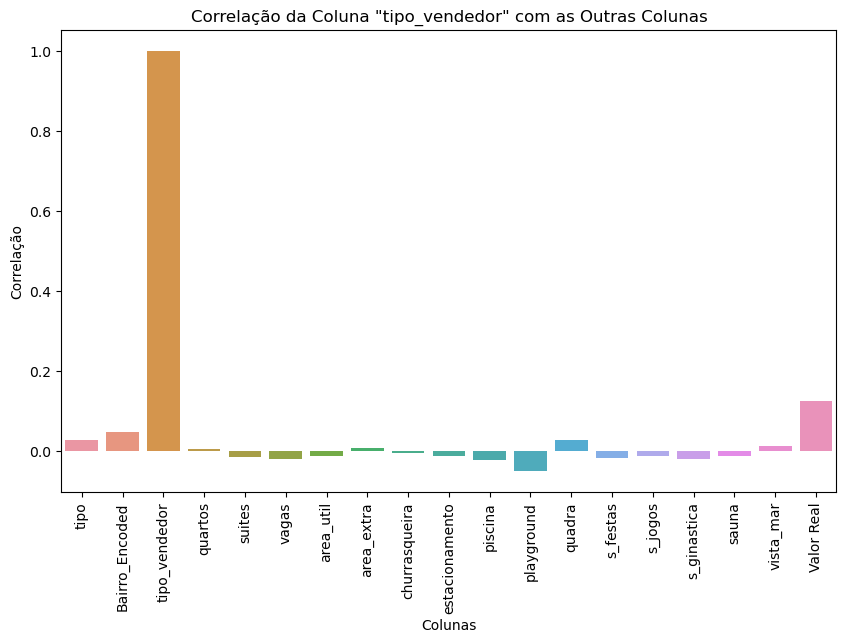

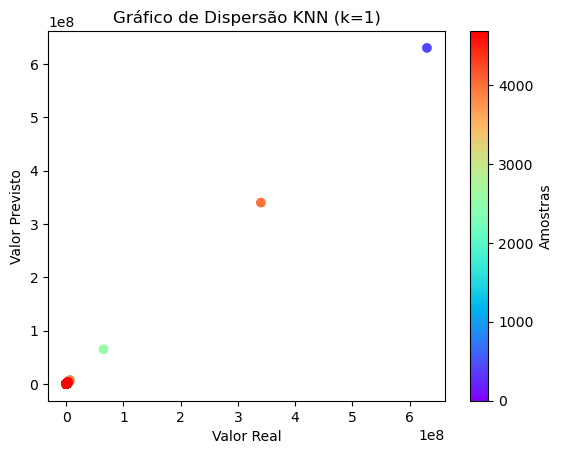

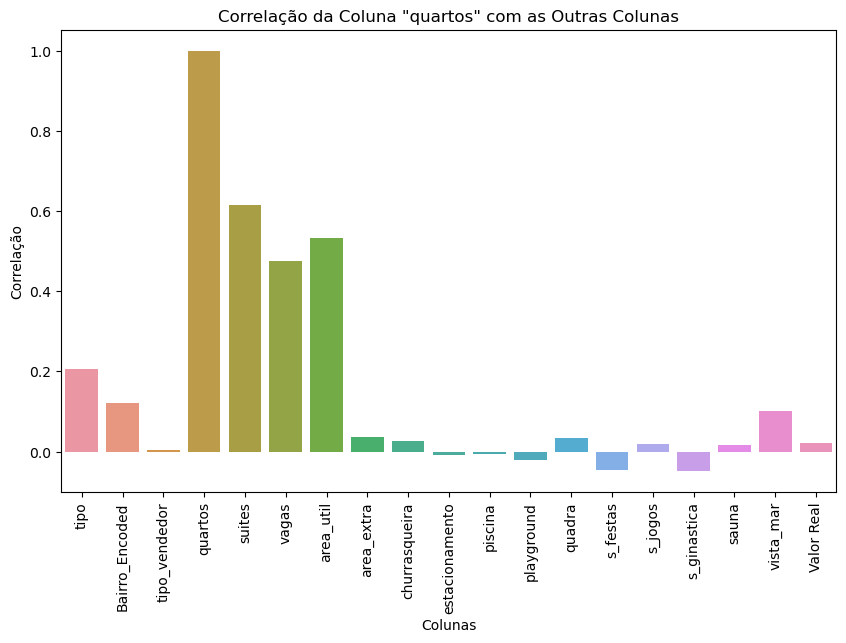

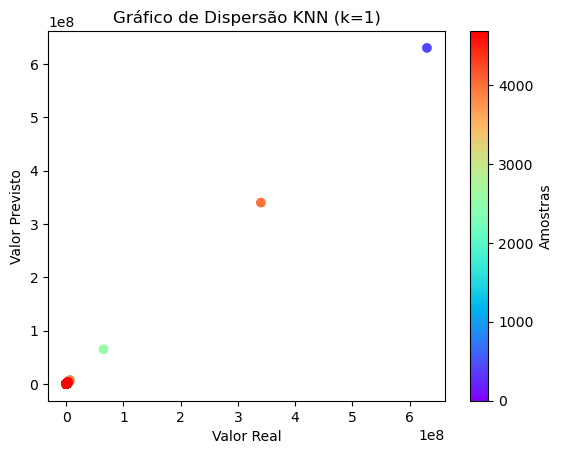

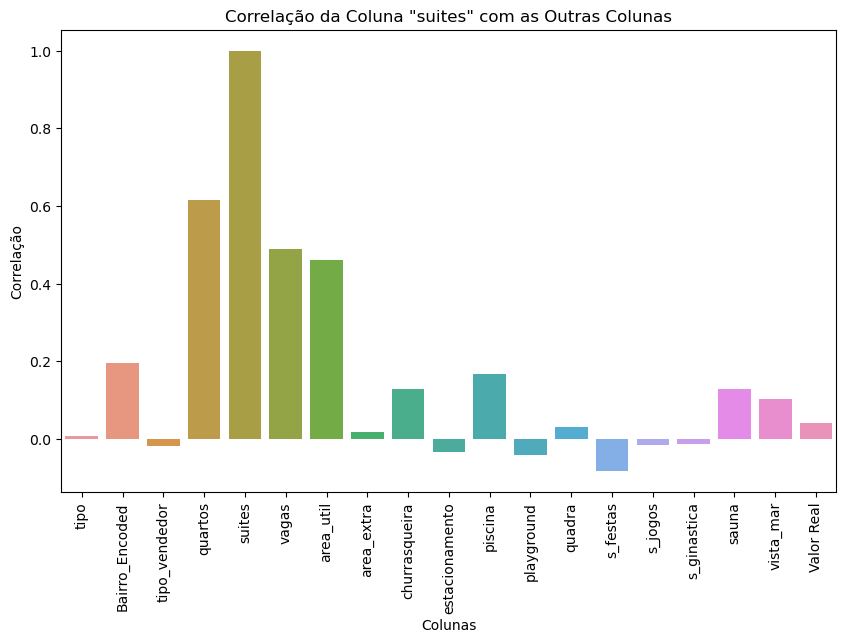

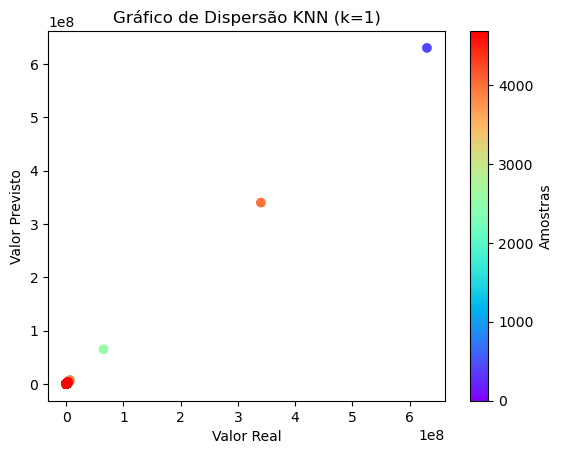

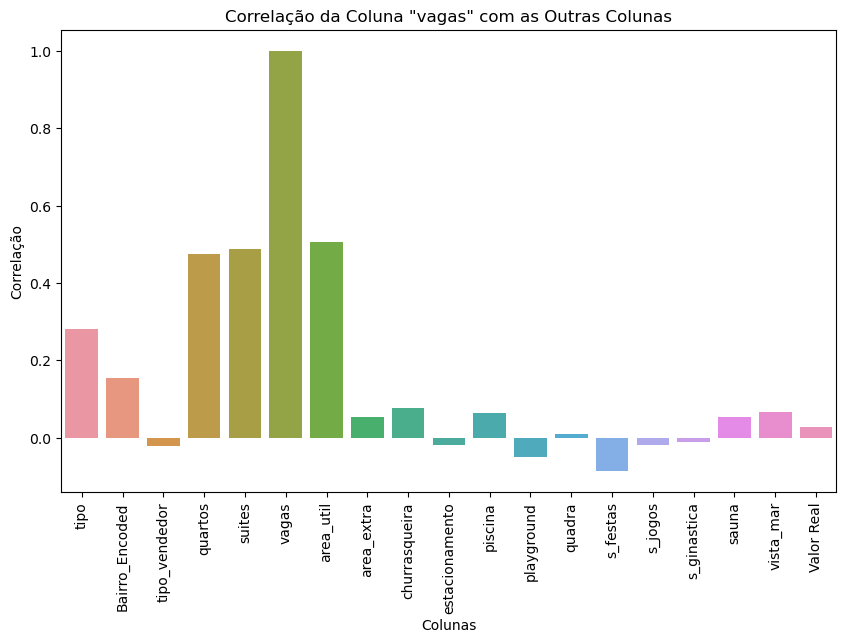

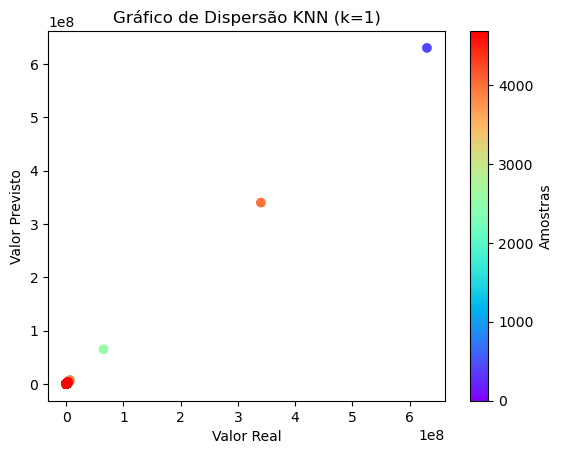

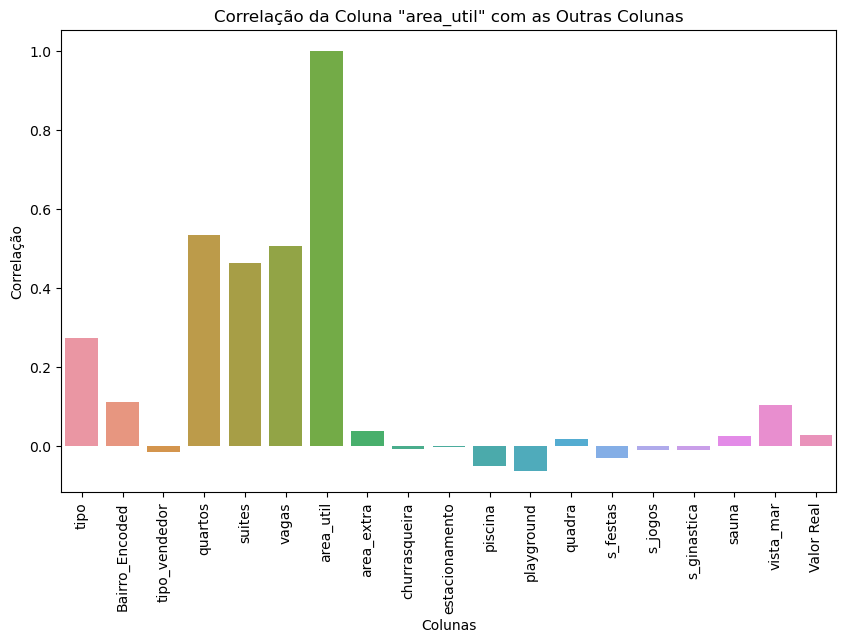

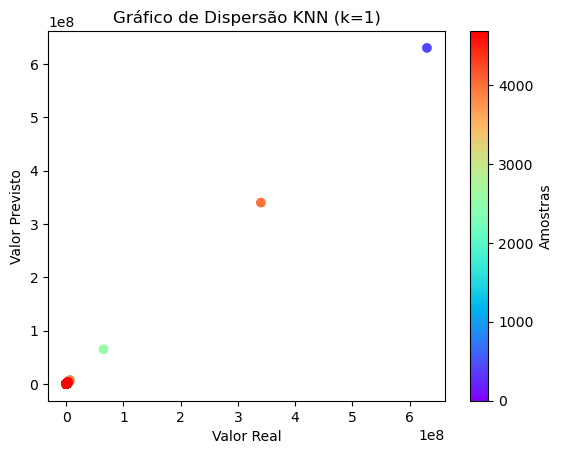

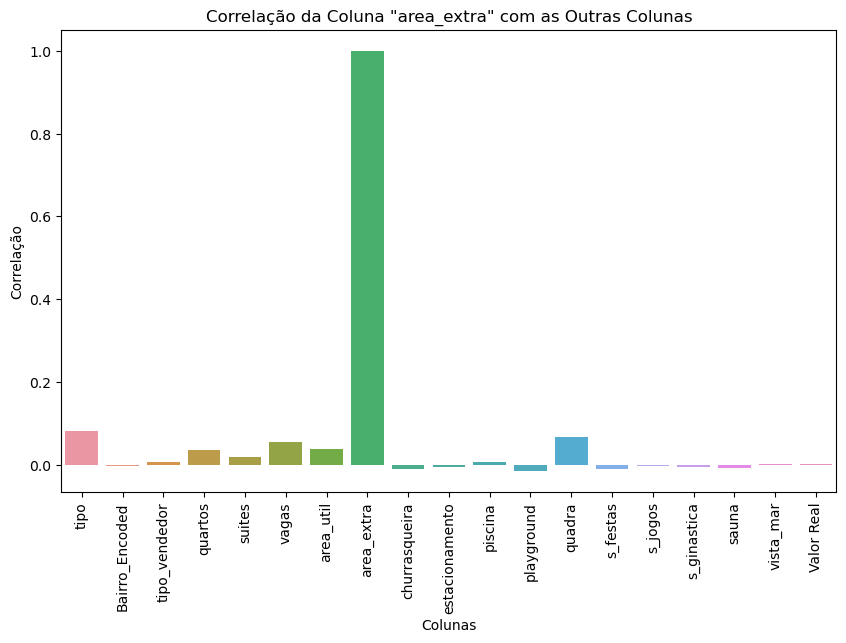

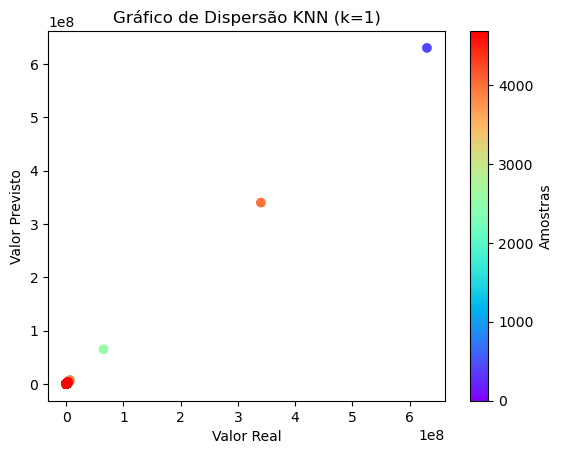

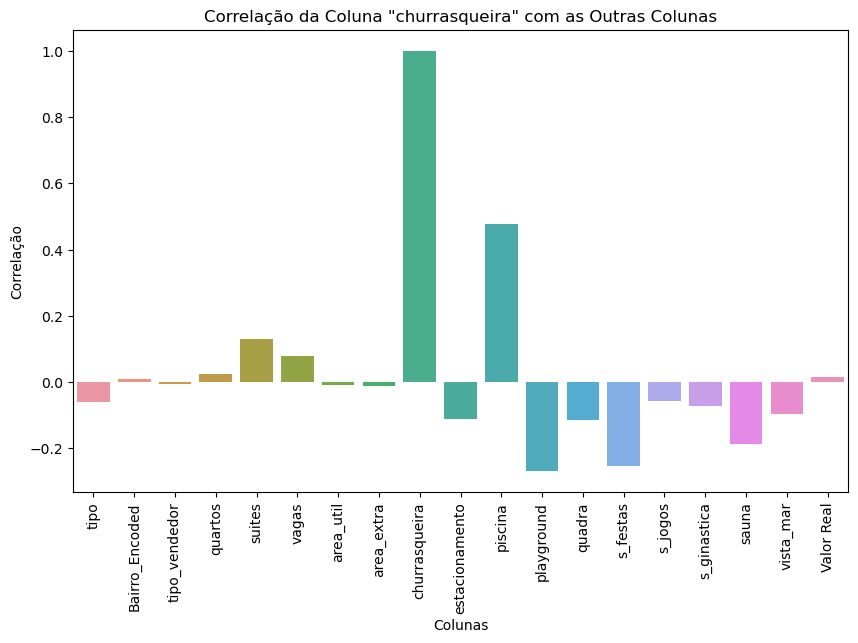

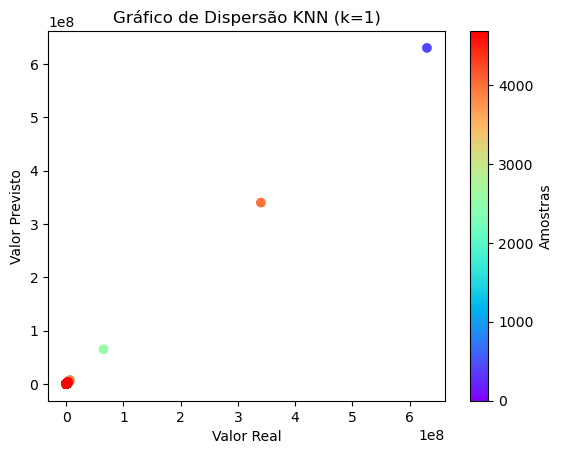

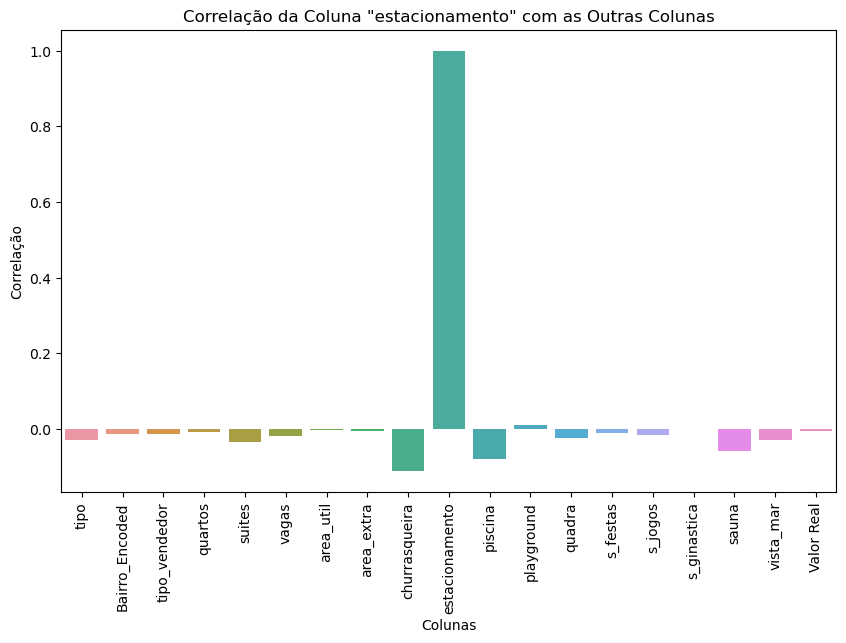

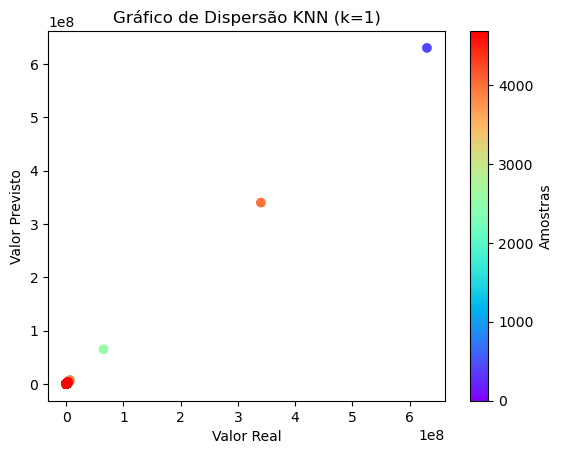

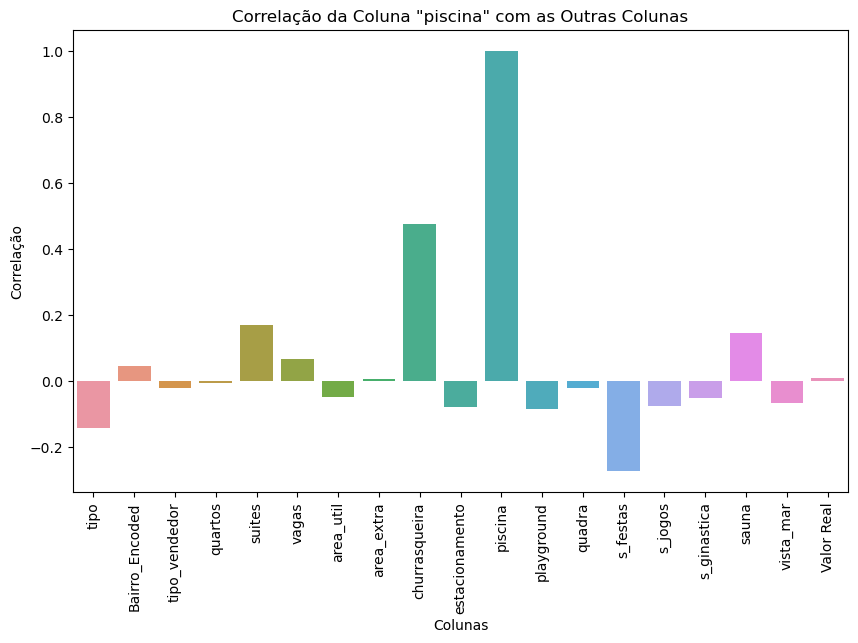

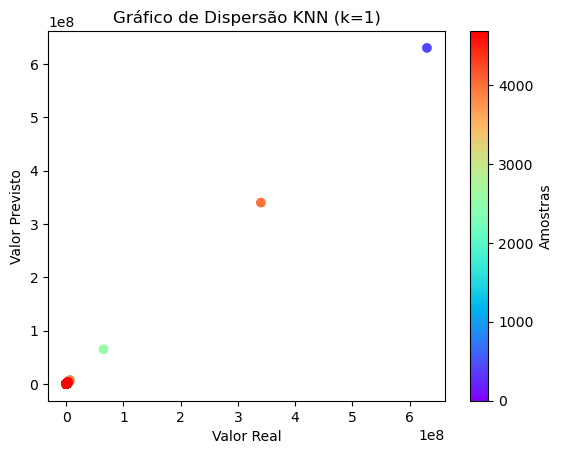

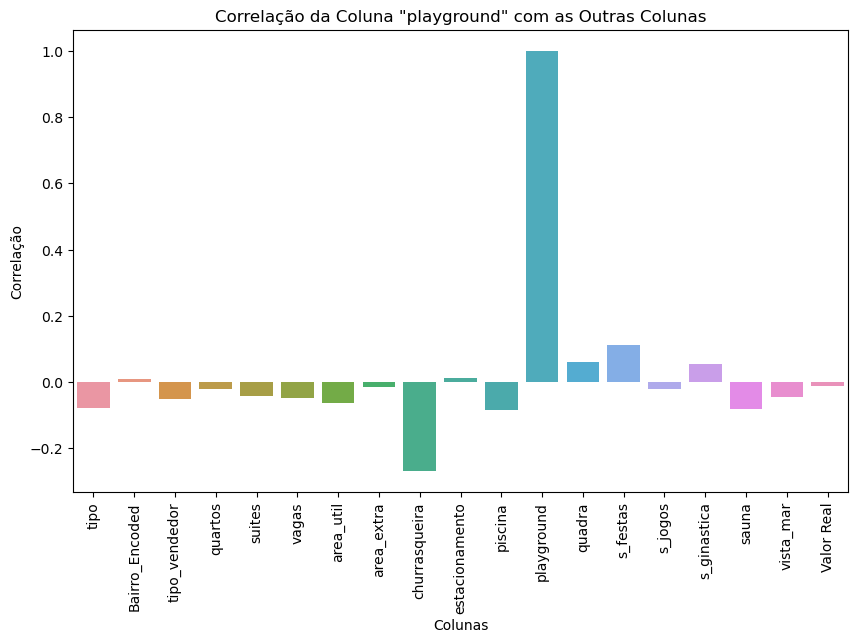

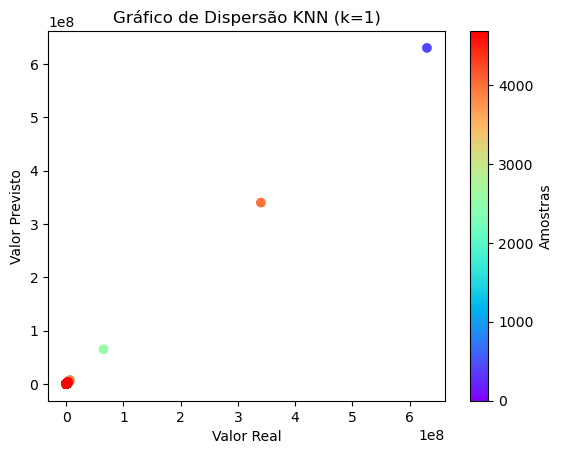

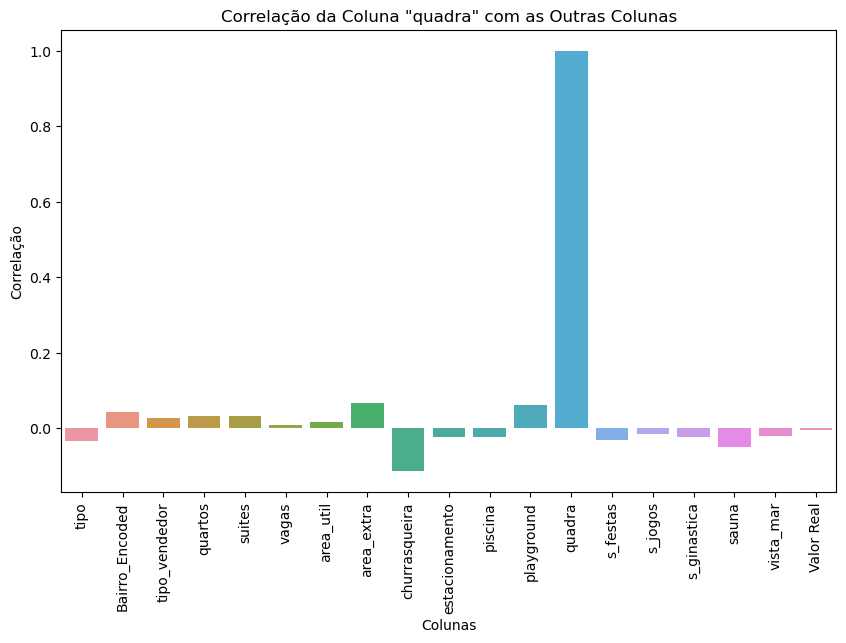

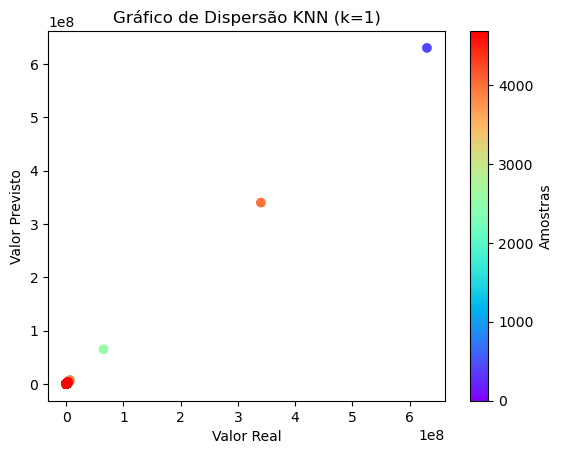

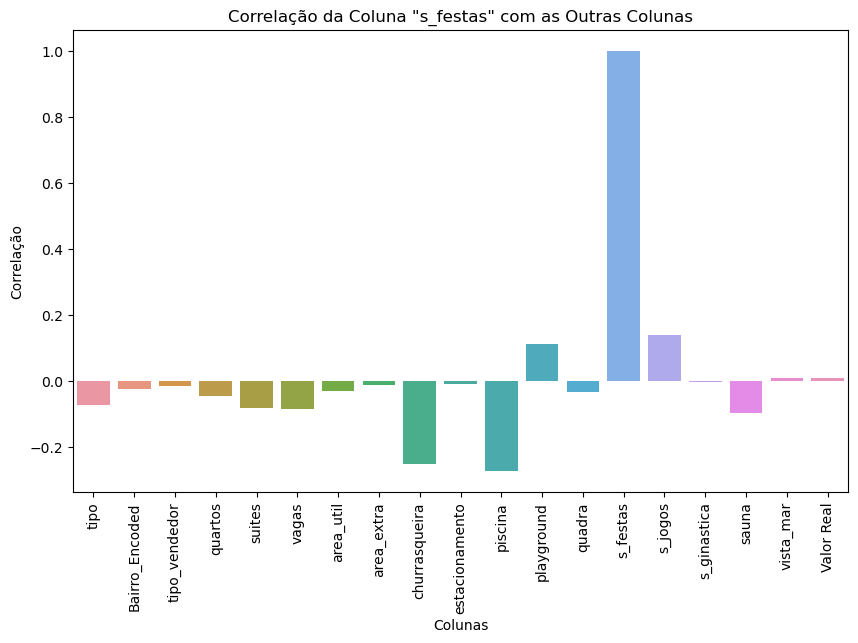

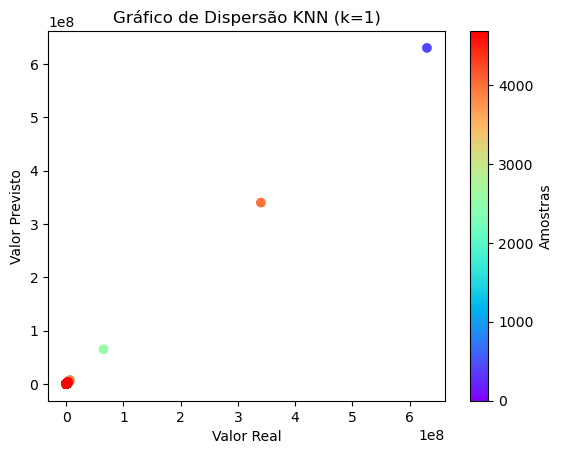

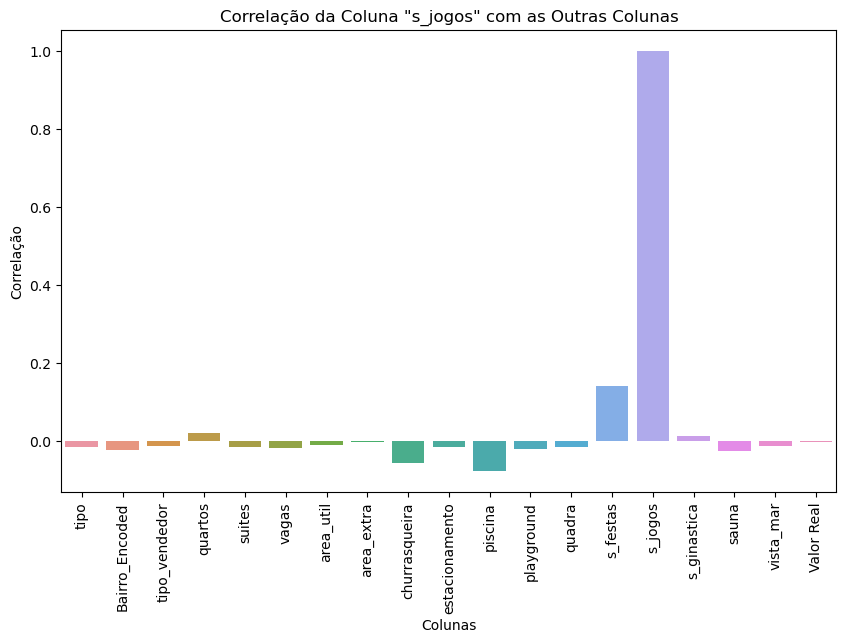

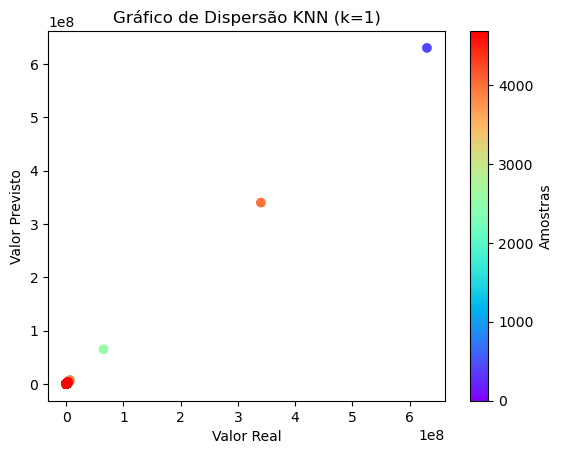

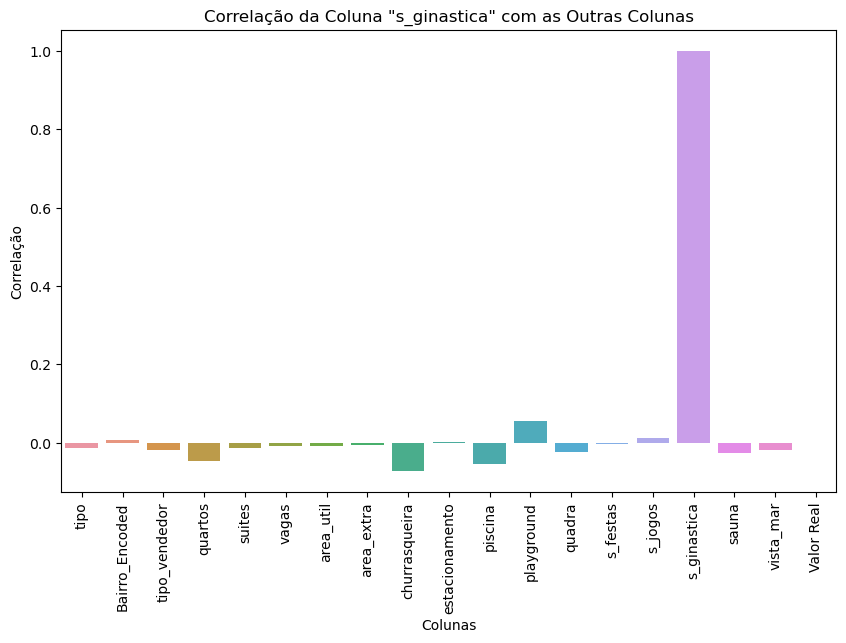

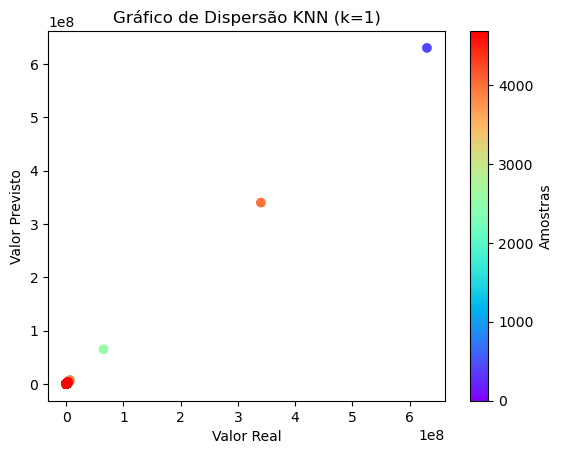

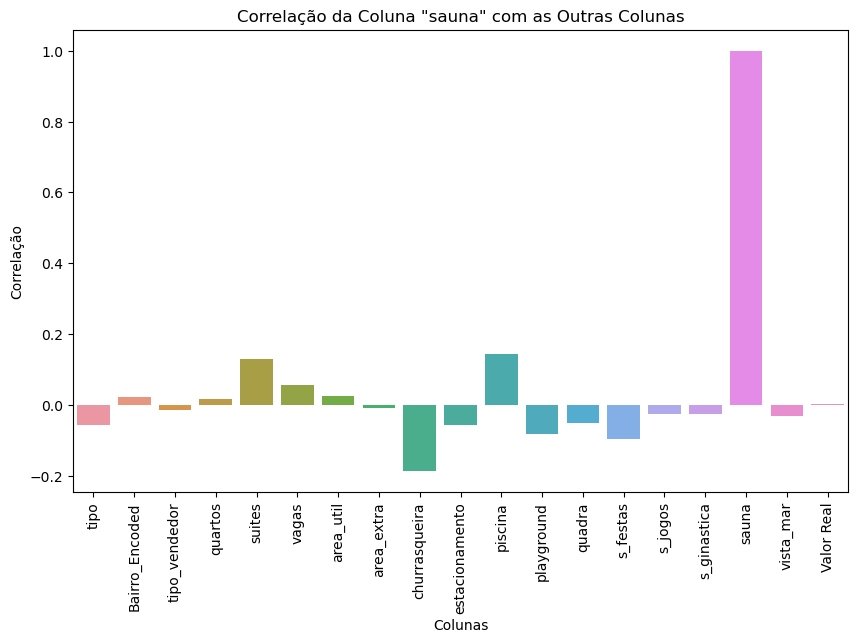

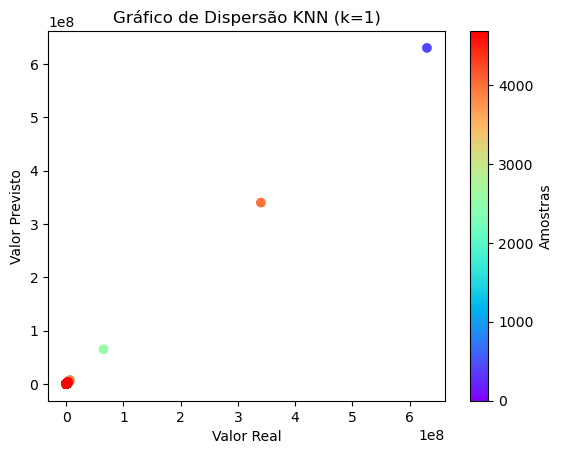

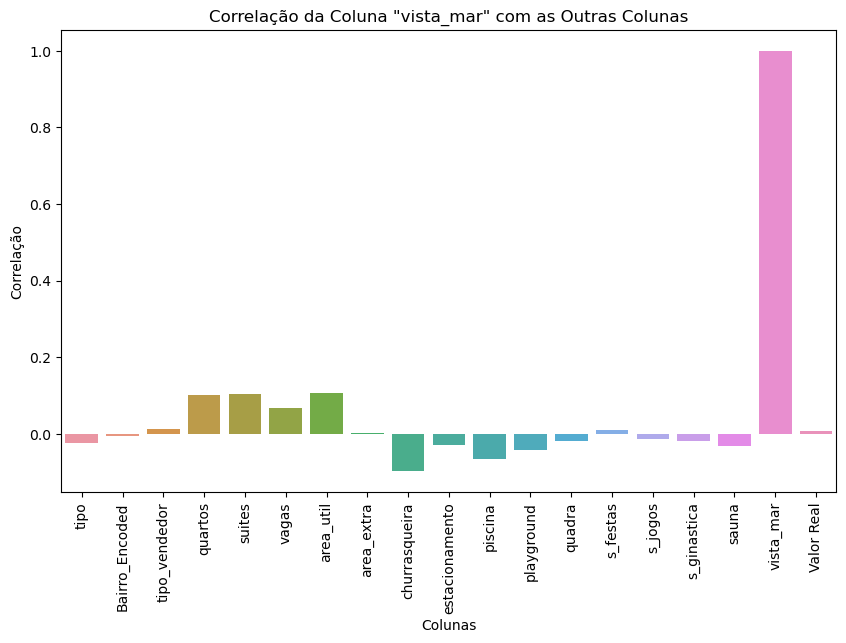

In [12]:
for i in range(18):
    visualize_knn(X_train, y_train, 1, i)

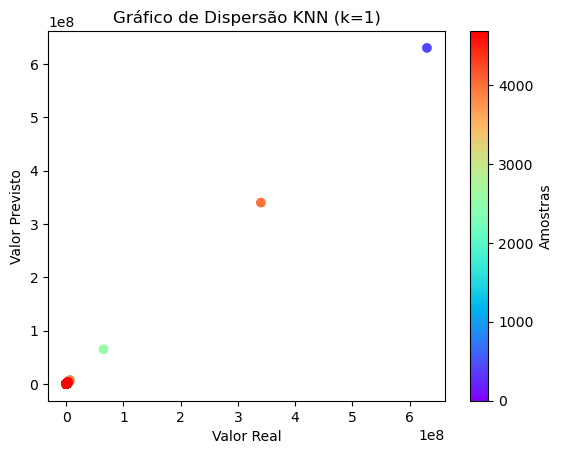

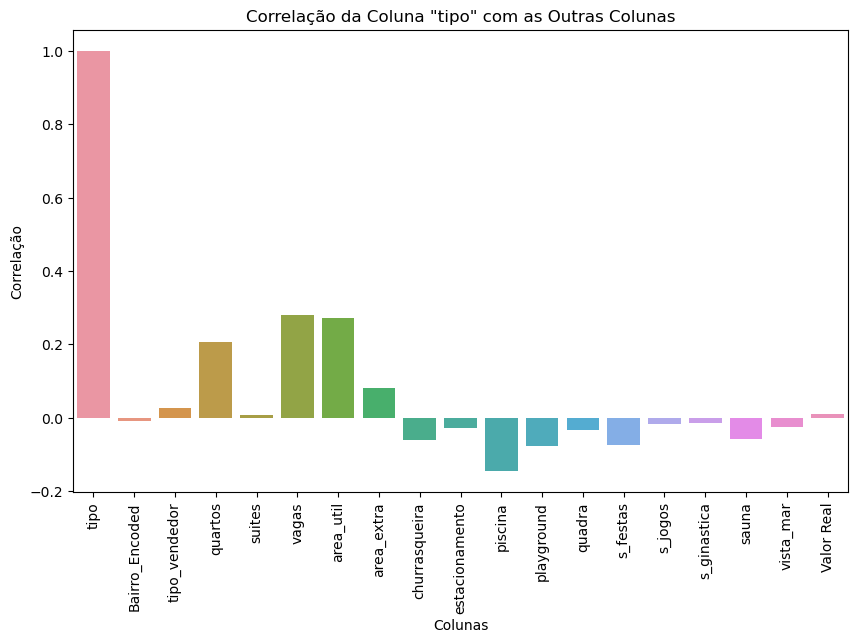

In [13]:
visualize_knn(X_train, y_train, 1, 0)